<h2 align=center>Data Visualization and Analysis of Worldwide Box Office Revenue </h2>

In [49]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajink\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [51]:
train.head()

1   
2                                            1   
3                                            0   
4                                            0   

   production_country_United Kingdom  production_country_France  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   
3                                  0                          0   
4                                  0                          0   

   production_country_Germany  production_country_Canada  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   production_country_India  production_country_Italy  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         1                         0   
4                         0                         0   

   production_country_Japan  production_country_Australia  \
0                         0                             0   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   

   production_country_Russia  production_country_Spain  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   production_country_China  production_country_Hong Kong  \
0                         0                             0   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   

   production_country_Ireland  production_country_Belgium  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   production_country_South Korea  production_country_Mexico  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               1                          0   

   production_country_Sweden  production_country_New Zealand  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

   production_country_Netherlands  production_country_Czech Republic  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   
4                               0                                  0   

   production_country_Denmark  production_country_Brazil  \
0                       

### Visualizing the Target Distribution

C:\Users\ajink\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



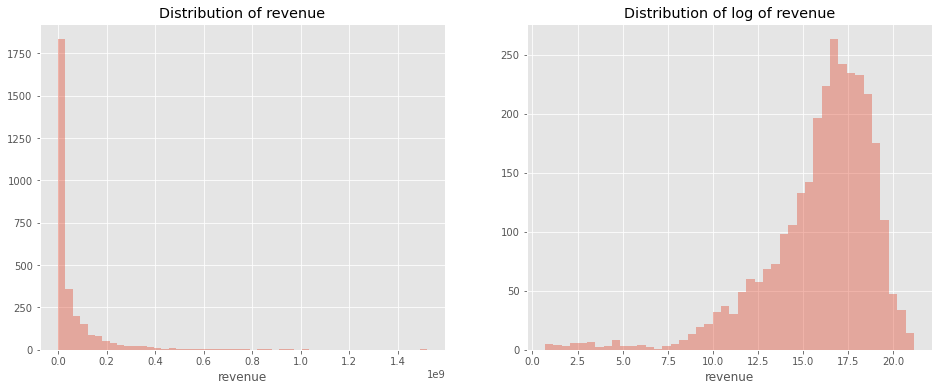

In [52]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.distplot(train['revenue'], kde=False);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['revenue']), kde=False);
plt.title('Distribution of log of revenue');

In [53]:
train['log_revenue'] = np.log1p(train['revenue'])

### Relationship between Film Revenue and Budget

In [54]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.distplot(train['budget'], kde=False);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['budget']), kde=False);
plt.title('Distribution of log of budget');

C:\Users\ajink\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\ajink\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



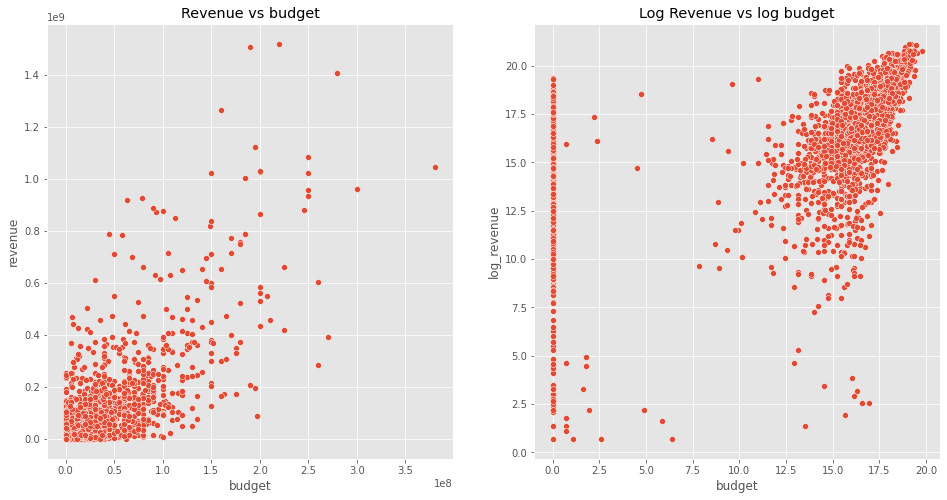

In [55]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
sns.scatterplot(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [56]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### Does having an Official Homepage Affect Revenue?

In [57]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                     4
http://www.thehobbit.com/                             2
http://www.lordoftherings.net/                        2
http://www.3bahadurmovie.com/                         1
http://www.hanselandgretelmovie.com/                  1
http://www.dancingwerewolves.com/                     1
http://focusfeatures.com/its_kind_of_a_funny_story    1
http://www.mugabeandthewhiteafrican.com/              1
http://www.miramax.com/movie/sin-city/                1
http://www.weretheworldminefilm.com/                  1
Name: homepage, dtype: int64

In [58]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

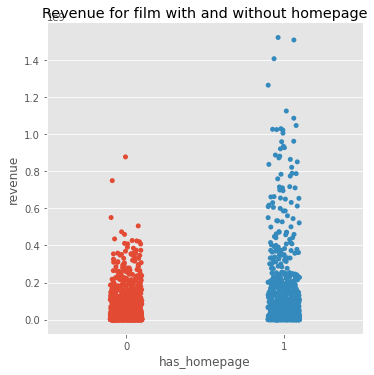

In [59]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

### As we can see from the above plot, Films with a homepage (webpage) earn better revenue than films without

### Distribution of Languages in Film

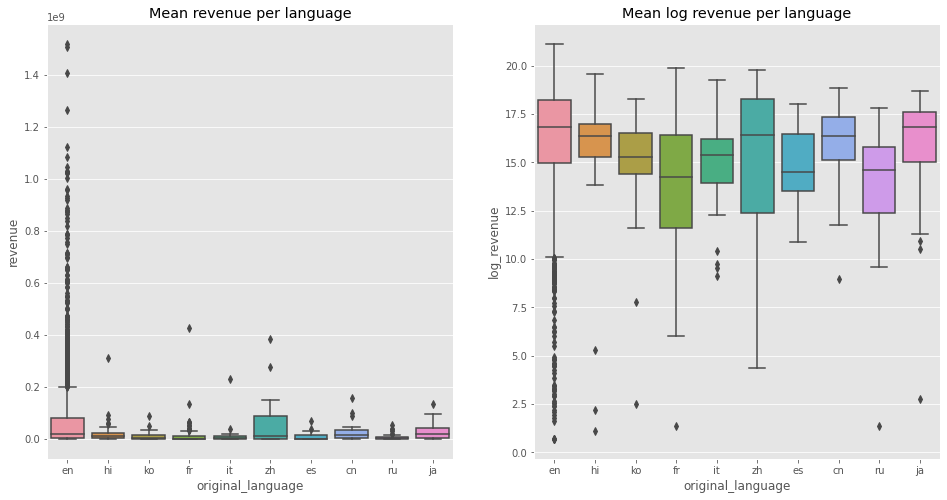

In [60]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

### From the above boxplots it is clear that English language films earn the most revenue followed by Hindi films then Korean and so on 

### Frequent Words in Film Titles and Descriptions

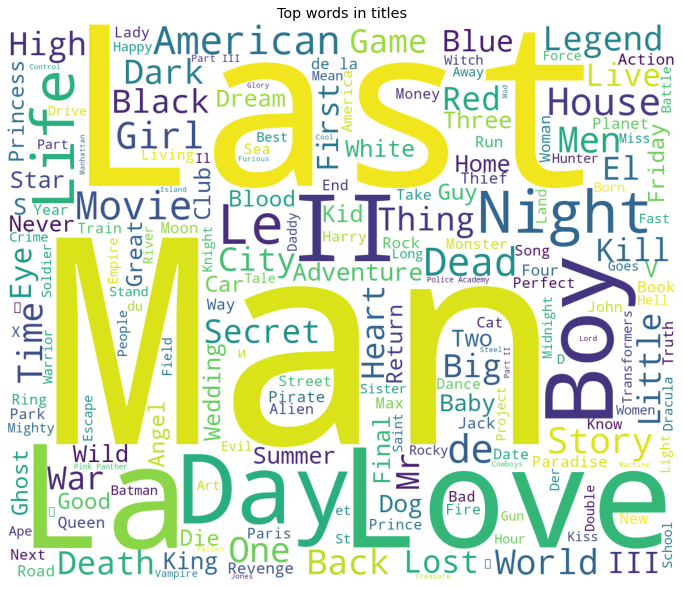

In [61]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

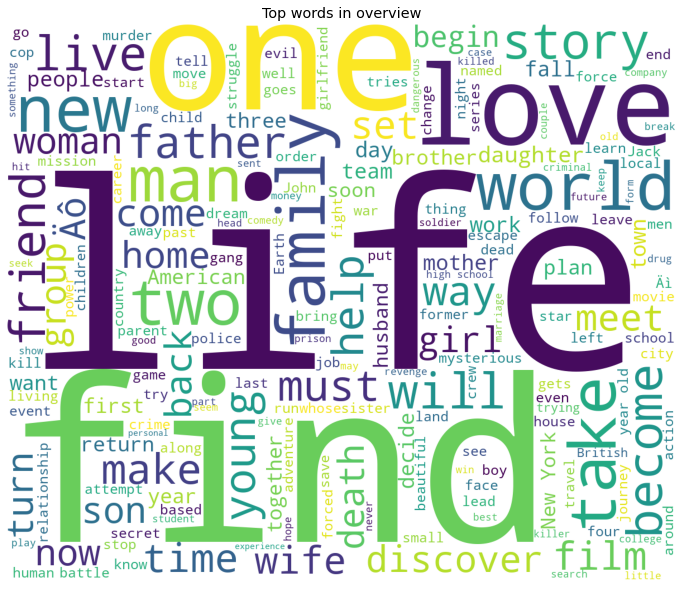

In [62]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

### Do Film Descriptions Impact Revenue?

In [63]:
import eli5

vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [64]:
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


### As we can see some words in film descriptions strongly affect the revenue 

### Analyzing Movie Release Dates

In [65]:
test.loc[test['release_date'].isnull() == False, 'release_date'].head()

0    7/14/07
1    5/19/58
2    5/23/97
3     9/4/10
4    2/11/05
Name: release_date, dtype: object

### Preprocessing Features


In [66]:
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [67]:
test.loc[test['release_date'].isnull() == True].head()

id  budget homepage    imdb_id original_language  \
828  3829       0      NaN  tt0210130                en   

                 original_title  \
828  Jails, Hospitals & Hip-Hop   

                                              overview  popularity  \
828  Jails, Hospitals &amp; Hip-Hop is a cinematic ...    0.009057   

    poster_path release_date  runtime status  \
828         NaN          NaN     90.0    NaN   

                                               tagline  \
828  three worlds / two million voices / one genera...   

                          title Keywords collection_name  has_collection  \
828  Jails, Hospitals & Hip-Hop       {}               0               0   

     num_genres all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
828           1      Drama            1             0               0   

     genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
828             0              0            0                0             0   

     genre_Science Fiction  genre_Family  genre_Fantasy  genre_Mystery  \
828                      0             0              0              0   

     genre_Animation  genre_History  genre_Music  num_companies  \
828                0              0            0              0   

     production_company_Warner Bros.  production_company_Universal Pictures  \
828                                0                                      0   

     production_company_Paramount Pictures  \
828                                      0   

     production_company_Twentieth Century Fox Film Corporation  \
828                                                  0           

     production_company_Columbia Pictures  \
828                                     0   

     production_company_Metro-Goldwyn-Mayer (MGM)  \
828                                             0   

     production_company_New Line Cinema  \
828                                   0   

     production_company_Touchstone Pictures  \
828                                       0   

     production_company_Walt Disney Pictures  \
828                                        0   

     production_company_Columbia Pictures Corporation  \
828                                                 0   

     production_company_TriStar Pictures  production_company_Relativity Media  \
828                                    0                                    0   

     production_company_Canal+  production_company_United Artists  \
828                          0                                  0   

     production_company_Miramax Films  \
828                                 0   

     production_company_Village Roadshow Pictures  \
828                                             0   

     production_company_Regency Enterprises  production_company_BBC Films  \
828                                       0                             0   

     production_company_Dune Entertainment  \
828                                      0   

     production_company_Working Title Films  \
828                                       0   

     production_company_Fox Searchlight Pictures  \
828                                            0   

     production_company_StudioCanal  production_company_Lionsgate  \
828                               0                             0   

     production_company_DreamWorks SKG  production_company_Fox 2000 Pictures  \
828                                  0                                     0   

     production_company_Summit Entertainment  \
828                                        0   

     production_company_Hollywood Pictures  production_company_Orion Pictures  \
828                                      0                                  0   

     production_company_Amblin Entertainment  \
828                                        0   

     production_company_Dimension Films  num_countries  \
828                                   0              0   

     production_country_Un

In [68]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '05/01/00'

In [69]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))

### Creating Features Based on Release Date

In [70]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [71]:
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

<ipython-input-71-e5034e7ba01c>:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



### Using Plotly to Visualize the Number of Films Per Year

In [72]:
# Count no.of films released per year and sort the years in ascending order
# Do this for both Train and Test Sets
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# x values are years, and y values are movie counts, name=legend
data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
        go.Scatter(x=d2.index, y=d2.values, name='test')]

layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

### Number of Films and Revenue Per Year

In [73]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'),
        go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]

layout = go.Layout(dict(title = "Number of films and total revenue per year",
                        xaxis = dict(title = 'Year'),
                        yaxis = dict(title = 'Count'),
                        yaxis2=dict(title='Total revenue', overlaying='y', side='right')),
                   legend=dict(orientation="v"))

py.iplot(dict(data=data, layout=layout))

In [74]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'),
        go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]

layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

### Do Release Days Impact Revenue?

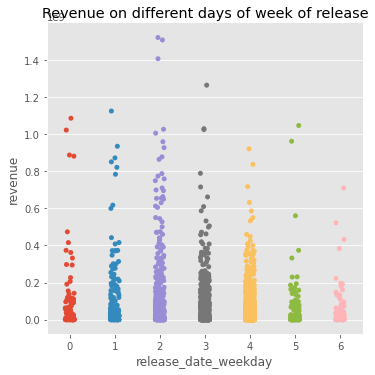

In [75]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

### Films released on Tuesdaya and Wednesdays generally earn more revenue 

### Relationship between Runtime and Revenue

C:\Users\ajink\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ajink\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



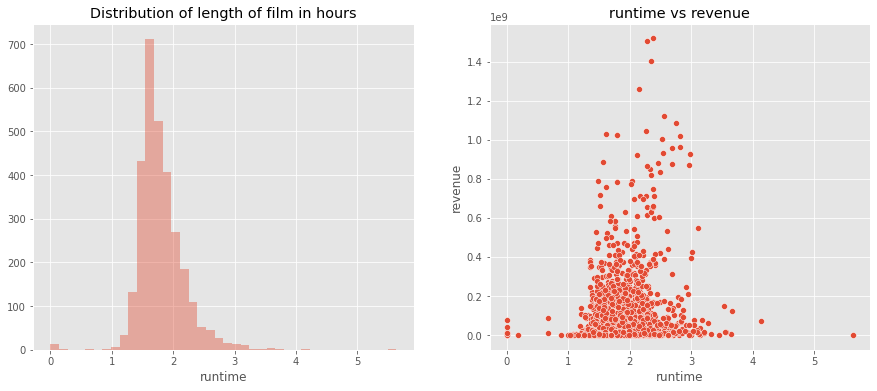

In [76]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.distplot(train['runtime'].fillna(0) / 60, bins=40, kde=False);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 2, 2)
sns.scatterplot(train['runtime'].fillna(0)/60, train['revenue'])
plt.title('runtime vs revenue');

### It is clear that films with a runtime of 1 to 3 hours earn maximum revenue. Anything below or above that is not profitable

### Highest Grossing Genres

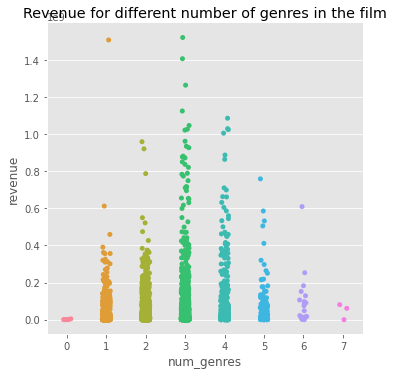

In [77]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

### Production Company and Country wise revenue

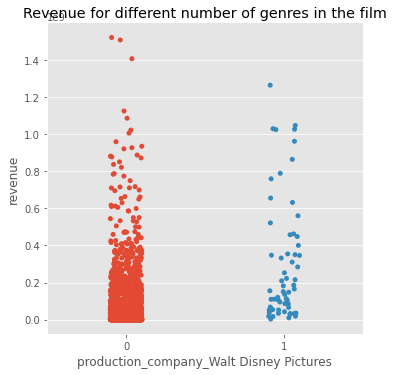

In [80]:
sns.catplot(x='production_company_Walt Disney Pictures', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

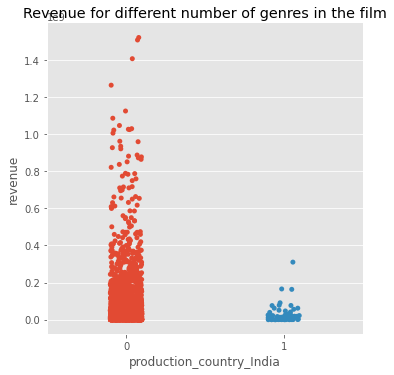

In [82]:
sns.catplot(x='production_country_India', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');


### As can be seen from both plots, Walt Disney accounts for a fair share of global revenue whereas India accounts for a less percentage of global film revenue